# Quantum embeddings

This notebook will take you into some different approaches one may have to encode classical data into a quantum states. 

We will take as a basis the Iris dataset due to its size and being all numeric features.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
iris['data'][:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

So the simplest encoding schemes we can think of are _angle_ and _amplitude_ encoding. Basis encoding even though it is also an option, is very likely no real dataset will meet the simplistic approach it provides.

Basis encoding can be expressed as
$$
\sum_{n=1}^t b_n\frac{1}{2^n}
$$
where $b_n$ corresponds to a bitwise representation of the information we would like to encode. Tends to be rather largish and not sure about the bitwise relevance when the algorithm is performed. This is why more expressive representations have been used in general.

[PennyLane Template](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html)

## Angle encoding

Just adding the value to the rotation angle of a given gate $R_x(\theta)$ can be the easiest way to encode data although requires normalization no to exceed the limit of the angle to be encoded. It also adds a circular relationship being 0 and $2\pi$ values equal when it comes to encoding.

```py
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(feature_vector):
    qml.AngleEmbedding(features=feature_vector, wires=range(3), rotation='Z')
    qml.Hadamard(0)
    return qml.probs(wires=range(3))
```

[PennyLane Template](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html)

## Amplitude encoding

Normalizing the different values on a value array can lead to an amplitud base representation that maps each value position to the amplitud of its basis state.

```py
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(2), normalize=True)
    return qml.state()
```

[PennyLane Template](https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html)


### IQP encoding

A common encoding scheme one can use is the ZZ feature map (part of the family of Instantaneous Quantum Polynomial time class and often called the IQP feature map as well). We encode the classical information vector $x$ on a quantum state $|x\rangle$ as

$$

|x\rangle = \left( U_z(x)H^{\otimes n}\right)^r|0\rangle^n,

$$

where $r$ is the depth of the circuit repeating the unitary

$$

U_z(x) = \Pi_{i,j} R_{z,z}(x_i, x_j) \bigotimes_{k=1}^n R_z(x_k)

$$

followed by a layer of $H^{}\otimes n$ at each repetition. This feature maps are used given their complexity when trying to simulate them classically.

**References**:
* https://arxiv.org/pdf/1804.11326.pdf
* https://arxiv.org/pdf/1504.07999.pdf

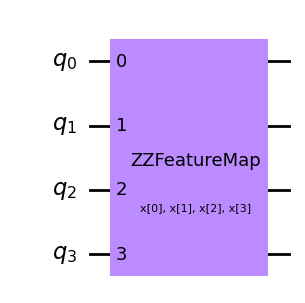

In [2]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement="linear")
feature_map.draw(output="mpl", style="clifford")

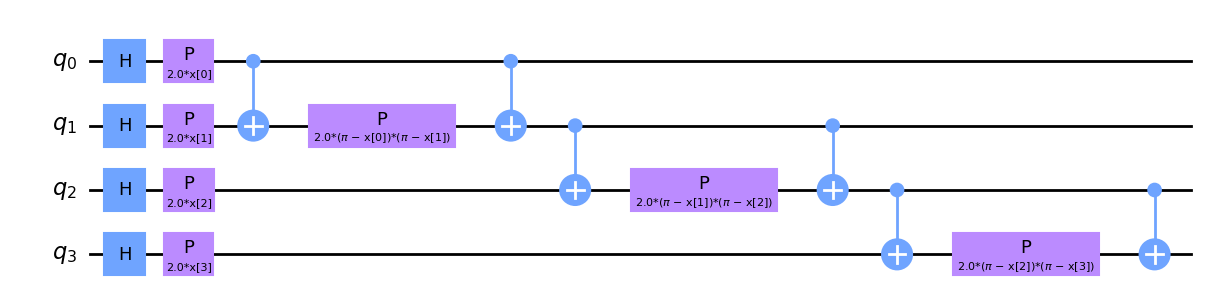

In [3]:
feature_map.decompose(reps=1).draw(output="mpl", style="clifford")

It can be generalized to any other Pauli gate combination of our liking. 

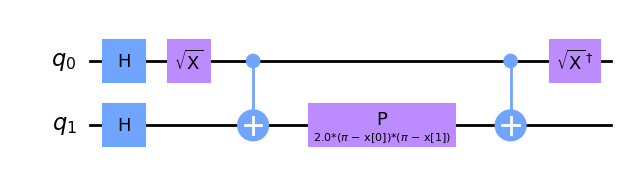

In [4]:
from qiskit.circuit.library import PauliFeatureMap

PauliFeatureMap(2, reps=1, paulis=['ZY']).decompose().draw('mpl', style="clifford")

Once the feature map is build, the kernel needs to be completed depending on our particular selection. In this case, we would like to evaluate the **Fidelity Kernel** therefore the feature map should be inverted for the second input vector ($k(x_1,x_2)$ below).

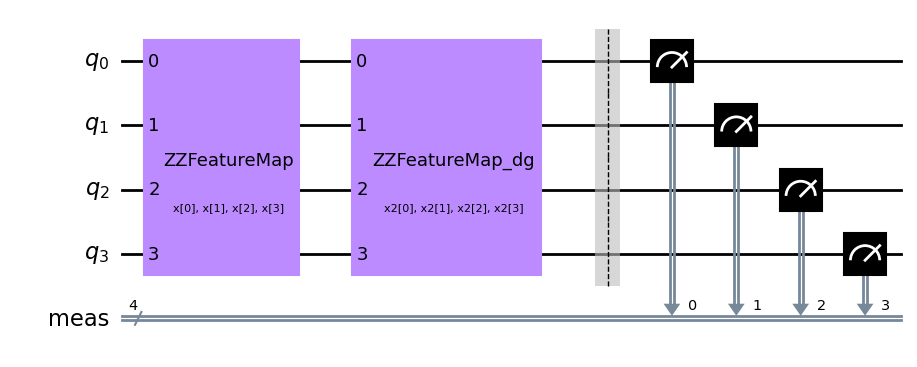

In [5]:
from qiskit.circuit import ParameterVector

# Change parameter names
x2_params = ParameterVector("x2", feature_map.num_parameters)
feature_map_y = feature_map.assign_parameters(x2_params)

fidelity_circ = feature_map.compose(feature_map_y.inverse())
fidelity_circ.measure_all()
fidelity_circ.draw(output="mpl", style="clifford")

In [6]:
X1 = iris.data[0]
X2 = iris.data[1]

print(f"X1 {X1}")
print(f"X2 {X2}")

X1 [5.1 3.5 1.4 0.2]
X2 [4.9 3.  1.4 0.2]


By simply measuring the success probability of the $|0\rangle^{\otimes n}$ state fidelity can be computed.

In [51]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

pub = [
    (fidelity_circ, [*X1, *X1]),
    (fidelity_circ, [*X2, *X2]),
    (fidelity_circ, [*X1, *X2]),
]
nshots = 1028
result = sampler.run(pub, shots=nshots).result()

In [55]:
counts = result[0].data.meas.get_counts()
print(f"K(X1,X1) = {counts['0000']/nshots}")

counts = result[1].data.meas.get_counts()
print(f"K(X2,X2) = {counts['0000']/nshots}")

counts = result[2].data.meas.get_counts()
print(f"K(X1,X2) = {counts['0000']/nshots}")

K(X1,X1) = 1.0
K(X2,X2) = 1.0
K(X1,X2) = 0.0963035019455253


This is what essentially Qiskit encapsulates in their Fidelity Quantum Kernel class.

In [64]:
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
kernel.evaluate(X1, X2)

/tmp/ipykernel_2705969/2397528620.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


array([[0.1061156]])

In order to introduce our data we will scale it so that each feature scale may not affect its performance.

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1.0,1.0))
X_scaled = scaler.fit_transform(iris.data)

In [69]:
import pennylane as qml
import pennylane.numpy as np

def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    n_wires = len(wires)
    for p, w in zip(params[1], wires):
        qml.CRZ(p, wires=[w % n_wires, (w + 1) % n_wires])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

adjoint_ansatz = qml.adjoint(ansatz)

def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

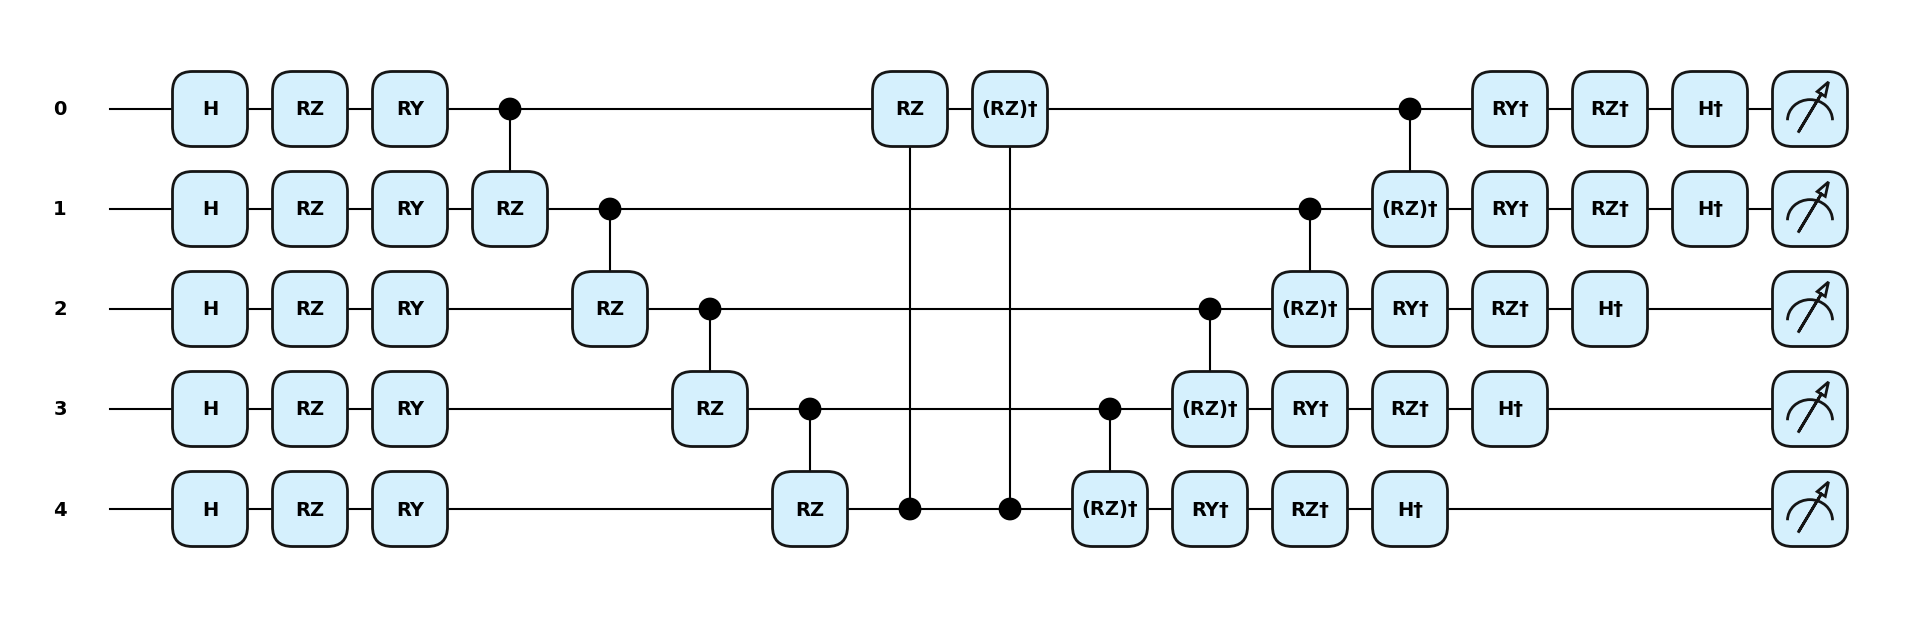

In [94]:
qml.drawer.use_style("pennylane")

params = random_params(num_wires=5, num_layers=1)
fig, ax = qml.draw_mpl(kernel_circuit)(X_scaled[0], X_scaled[0], params)

In [92]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

init_params = random_params(num_wires=5, num_layers=6)

kernel_value = kernel(X_scaled[0], X_scaled[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.676


In [ ]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X_scaled, init_kernel, assume_normalized_kernel=True)

In [77]:
X_scaled.shape

(150, 4)

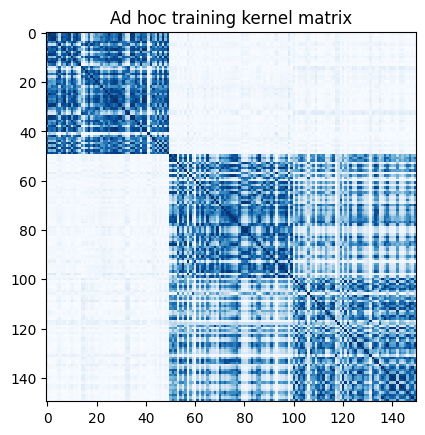

In [75]:
import matplotlib.pyplot as plt

plt.imshow(
    np.asmatrix(K_init), interpolation="nearest", origin="upper", cmap="Blues"
)
plt.title("Training kernel matrix")

plt.show()

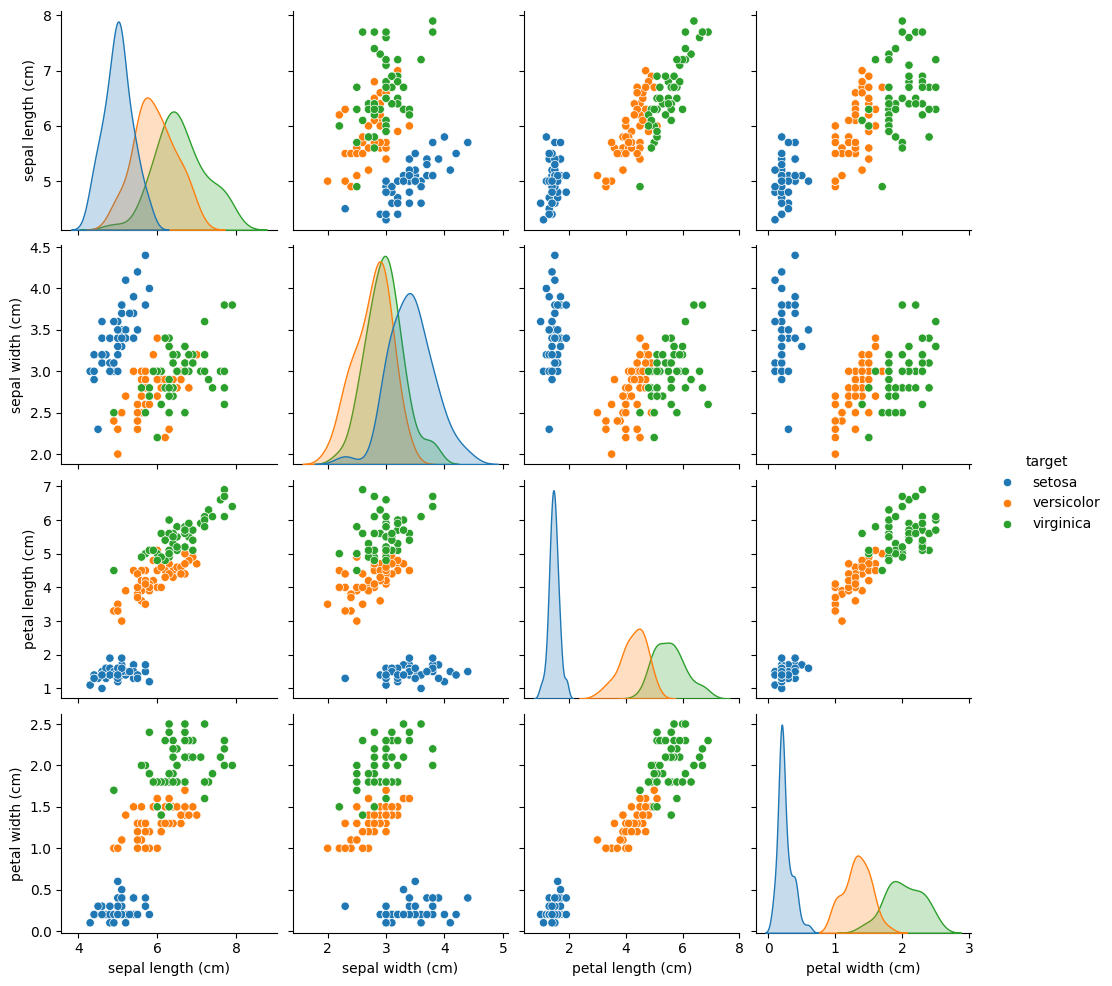

In [88]:
import seaborn as sns

iris = load_iris(as_frame=True)

# Rename classes using the iris target names
iris.frame["target"] = iris.target_names[iris.target]
_ = sns.pairplot(iris.frame, hue="target")

In [84]:
from sklearn.svm import SVC

svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_scaled, iris.target)

In [85]:
from sklearn.metrics import classification_report

y_pred = svm.predict(X_scaled)

print(classification_report(iris.target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.92      0.94      0.93        50
           2       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

